# 循环神经网络的高级用法
## 温度预测问题
### EDA

In [1]:
import os
data_dir = '../../data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
# 可以看出整个数据总共有420451个样本
# 每个样本记录了一个时间戳(每隔十分钟)和14个与温度相关的指标
print(header)
print(lines[1:2])
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
['01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10']
420451


In [2]:
# 使用numpy对原始数据进行转换
import numpy as np
# 创建一个矩阵，用来存储每个样本的气温指标
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    # 要把第一列的时间戳去掉
    values = [float(x) for x in line.split(',')[1:]]
    # 将这个样本放到矩阵中
    float_data[i, :] = values
print(float_data.shape)
float_data

(420451, 14)


array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

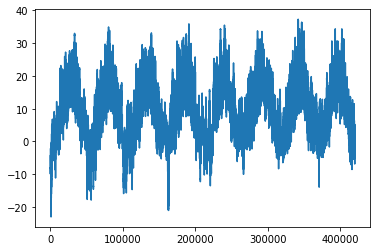

In [3]:
# 第一列存放的是我们的targe:温度，做一个可视化展示
# 基本上可以看到温度按照每年开一个窗口，季节性的变化
import matplotlib.pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

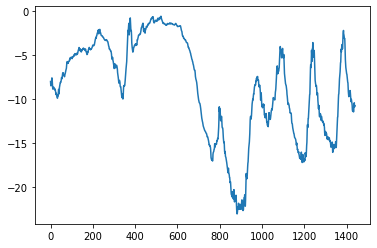

In [4]:
# 看一下前10天的温度情况，每天有1440分钟
plt.plot(range(1440), temp[:1440])

### 数据转换
- lookback=720: 观测过去多少个样本点
- steps=6: 观测数据的采样频率
- delay=144: 预测多少个步长后面的样本点

In [5]:
# 取前面200000个样本，先将其数据标准化
# 在样本轴的方向，即在每个特征的方向做归一化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

In [6]:
import pandas as pd
# 将数据转换成pandas的DataFrame
df = pd.DataFrame(float_data)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.900147,-1.931358,-1.982110,-1.862800,1.072852,-1.307422,-1.473758,-0.798686,-1.476267,-1.478155,2.123751,-0.729505,-0.780680,-0.276136
1,0.906043,-1.975414,-2.025670,-1.915830,1.078831,-1.320427,-1.495196,-0.800752,-1.495025,-1.499321,2.171999,-0.931240,-0.887945,-0.463174
2,0.901327,-1.986710,-2.036839,-1.920016,1.108722,-1.323028,-1.497578,-0.802818,-1.498776,-1.501673,2.182354,-1.276143,-1.261228,-0.053306
3,0.898968,-1.964118,-2.013384,-1.886524,1.126657,-1.316525,-1.483286,-0.804884,-1.483770,-1.487562,2.157642,-1.178529,-1.317006,0.251497
4,0.898968,-1.959599,-2.010033,-1.882337,1.120678,-1.315225,-1.480904,-0.804884,-1.483770,-1.485211,2.153170,-1.191544,-1.261228,0.439690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,1.318758,-1.482898,-1.568852,-1.755346,-0.134753,-1.152658,-1.428499,-0.592090,-1.431250,-1.435823,1.776130,-0.963778,-0.879364,0.736411
420447,1.302250,-1.403824,-1.489551,-1.745578,-0.337416,-1.120145,-1.423735,-0.546638,-1.427499,-1.431119,1.692814,-0.657921,-0.707739,0.670602
420448,1.289279,-1.382361,-1.467213,-1.766510,-0.445024,-1.111041,-1.433263,-0.523913,-1.435002,-1.440526,1.668102,-0.696967,-0.673415,0.450081
420449,1.288099,-1.503231,-1.586723,-1.811166,-0.212470,-1.160461,-1.452319,-0.583826,-1.457510,-1.459341,1.789781,-0.430155,-0.604765,0.572464


## 数据生成函数理解说明
最后生成的是一个3D张量，大小是(batch_size, lookback//steps, input_dim)

训练数据生成步骤:
- 特征空间数据采集:
  - 从第一个可以倒退时间点的样本点1440开始，作为第一次采样的基准点
  - 往回倒退10天，到了下标为0的那个样本点，从这个样本点开始每隔6个样本，采集一次数据，直到采集到下标为1440的样本点为止
  - 到此总共采集的了240个样本，到此第一个批量的第一个样本点的特征空间采集完毕。
  - 这样我们采集到的数据就成功包含了前10天的所有数据
  - 所以输入的张量为2D，形状为240x14
- 标签空间数据采集:
  - 从样本点1440开始，向后推迟一天，到达1584这个样本点，收集到它的目标值
  - 到此第一批的第一个样本点的标签空间采集完毕。
  - 所以输出的是一个标量，形状为1
- batch数据生成：
  - 样本基点向后移动1位，到达1441
  - 重复上面的过程：形成一个输入大小为240x14的张量，输出一个标量
  - 这样向后移动127次，整个batch数据生成完毕
- 备注：
  - 可以这样理解一个批量数据，每个批量中有128个样本
  - 每个样本中的输入是一个2D张量，大小是(lookback//steps, input_dim)，包含的是过去lookback//steps个样本点的特征空间数据
  - 每个样本的输出是一个标量，包含的是delay样本点的标签空间数据

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False,
            batch_size=128, step=6):
    # 采样终点的边界条件，会在生成测试数据集上用到
    if max_index is None:
        max_index = len(data) - delay - 1
    # 给出采样的基准点
    i = min_index + lookback
    while 1:
        if shuffle:
            # 随机生成一个大于等于min_index+lookback，小于max_index，长度为batch_size的数组
            # 在生成训练数据集上会跳到这个分支上
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            # 如果本次采样的最后节点越界
            if i+batch_size >= max_index:
                i = min_index + lookback
            # 从起点i开始，采集batch_size个数据
            rows = np.arange(i, min(i+batch_size, max_index))
            # 采样基准点开始向后移动batch_size个位置
            i += len(rows)
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        # 从这里开始生成一个batch
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            # 包含了过去lookback中的特征信息
            samples[j] = data[indices]
            # 包含了未来delay中的标签信息
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=0, max_index=200000, shuffle=True,
                    step=step, batch_size=batch_size)

# train_gen = generator(float_data, lookback=lookback, delay=delay,
#                     min_index=0, max_index=200000, shuffle=True,
#                     step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000, shuffle=False,
                    step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=300001, max_index=None, shuffle=False,
                    step=step, batch_size=batch_size)
# 验证数据集上总共的批次                
val_steps = (300000 - 200001 - lookback) // batch_size
# 测试数据集上总共的批次
test_steps = (len(float_data) - 300001 - lookback) // batch_size                

In [9]:
# 查看一下生成的特征空间和标签空间
import numpy as np
i = 1
for d in train_gen:
    i += 1
    # 第一个参数是选择sample/target，第二个是当前batch的索引
    print(np.asarray(d[0][0]).shape)
    print(np.asarray(d[1]).shape)
    if i >=1:
        break

(240, 14)
(128,)


# 基准方法构建
- 机器学习的本质就是在假设空间中寻找最合理的那个，就是蒙的最准的那个
- 我们在这个假设空间中，应该先选择比较简单的那个，也就是瞎蒙的时候蒙的比较准的那个
- 要先评估出这个简单模型的成色，保证我们构建出来的机器学习模型比这个模型好，我们的模型才有意义
- 我们优化模型才有方向感
- 这里模型的基准我们认为一天后的温度就是当天的温度

In [11]:
def evaluate_naive_methond():
    # 所有批次上的mae列表
    batch_maes = []
    for step in range(val_steps):
        # 取出当前批次的样本空间和标签空间
        samples, targets = next(val_gen)
        # 取出当前批次的每个批次的最后一个样本的第二列值，即当天的温度，形状为128*1
        preds = samples[:, -1, 1]
        # 计算当前批次的mae
        mae = np.mean(np.abs(preds - targets))
        # 将当前批次的mae加入到mae列表中
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_methond()

0.2897359729905486


# 使用全连接层
- 使用最简单的神经网络，看一下这个在这个数据集上的表现
- 效果不理想，最开始的时候就发生了过拟合
- 而且损失值一直在0.3以上，还没有基准模型好

In [13]:
from keras.models import Sequential
from keras import layers

In [14]:
model = Sequential()
# 接受的是每个样本的大小：(1440//6, 14)
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
# 编译模型
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


2022-04-21 11:42:03.960028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 11:42:03.960056: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 11:42:03.960073: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yy): /proc/driver/nvidia/version does not exist
2022-04-21 11:42:03.960692: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_3291/3344692307.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a f

500/500 [==============================] - 8s 15ms/step - loss: 1.5508 - val_loss: 0.7616
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5021 - val_loss: 0.3091
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3030 - val_loss: 0.3826
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2712 - val_loss: 0.3258
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2568 - val_loss: 0.3150
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2450 - val_loss: 0.3405
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2385 - val_loss: 0.3174
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2312 - val_loss: 0.3176
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2259 - val_loss: 0.3469
Epoch 10/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2233 - val_loss: 0.3143

In [15]:
history.history

{'loss': [1.5508402585983276,
  0.5021030306816101,
  0.3030432462692261,
  0.27121177315711975,
  0.2567961812019348,
  0.24500887095928192,
  0.23847126960754395,
  0.2311759740114212,
  0.22592629492282867,
  0.22328798472881317,
  0.21864984929561615,
  0.21669745445251465,
  0.213777095079422,
  0.20926743745803833,
  0.20827779173851013,
  0.2054533213376999,
  0.20283646881580353,
  0.20108768343925476,
  0.20093555748462677,
  0.19824181497097015],
 'val_loss': [0.7615841627120972,
  0.3090883195400238,
  0.3826267421245575,
  0.32576924562454224,
  0.31501442193984985,
  0.34045329689979553,
  0.3174233138561249,
  0.3176271617412567,
  0.346894234418869,
  0.31429392099380493,
  0.3160513639450073,
  0.3709068298339844,
  0.35405293107032776,
  0.33092719316482544,
  0.32307711243629456,
  0.3609321117401123,
  0.33131280541419983,
  0.35370761156082153,
  0.3390175998210907,
  0.34422045946121216]}

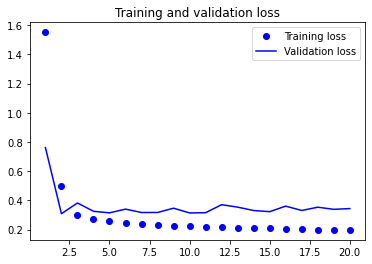

In [18]:
# 将结果可视化
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 使用dropout降低过拟合
- 使用dropout抑制了过拟合，在大概第10个epoch时，才开始有了过拟合的趋势
- 验证集的损失得到了一定的下降，大概在0.28，这个是要比基准模型好的

In [23]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,validation_data=val_gen, validation_steps=val_steps)
history.history

Epoch 1/40


/tmp/ipykernel_3291/1123418728.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,validation_data=val_gen, validation_steps=val_steps)


500/500 [==============================] - 74s 146ms/step - loss: 0.3268 - val_loss: 0.2765
Epoch 2/40
500/500 [==============================] - 75s 151ms/step - loss: 0.3044 - val_loss: 0.2828
Epoch 3/40
500/500 [==============================] - 75s 149ms/step - loss: 0.2953 - val_loss: 0.2738
Epoch 4/40
500/500 [==============================] - 74s 149ms/step - loss: 0.2916 - val_loss: 0.2700
Epoch 5/40
500/500 [==============================] - 75s 150ms/step - loss: 0.2867 - val_loss: 0.2724
Epoch 6/40
500/500 [==============================] - 75s 151ms/step - loss: 0.2836 - val_loss: 0.2762
Epoch 7/40
500/500 [==============================] - 75s 150ms/step - loss: 0.2778 - val_loss: 0.2745
Epoch 8/40
500/500 [==============================] - 75s 149ms/step - loss: 0.2744 - val_loss: 0.2790
Epoch 9/40
500/500 [==============================] - 75s 149ms/step - loss: 0.2710 - val_loss: 0.2806
Epoch 10/40
500/500 [==============================] - 75s 150ms/step - loss: 0.2686

{'loss': [0.32678186893463135,
  0.304362028837204,
  0.29534992575645447,
  0.2916035056114197,
  0.28674352169036865,
  0.28360089659690857,
  0.27775439620018005,
  0.2743702828884125,
  0.27095460891723633,
  0.2685873806476593,
  0.26559218764305115,
  0.2622157335281372,
  0.2598865032196045,
  0.2590439021587372,
  0.2572084665298462,
  0.2560865879058838,
  0.2528262138366699,
  0.2523791193962097,
  0.24883194267749786,
  0.24640776216983795,
  0.2451847493648529,
  0.24303144216537476,
  0.24112598598003387,
  0.23962505161762238,
  0.23846501111984253,
  0.2377215027809143,
  0.2348778247833252,
  0.23475733399391174,
  0.23207177221775055,
  0.2327553927898407,
  0.23240414261817932,
  0.22913694381713867,
  0.22867408394813538,
  0.22913487255573273,
  0.22668392956256866,
  0.22583264112472534,
  0.22492079436779022,
  0.22301441431045532,
  0.22190944850444794,
  0.22231735289096832],
 'val_loss': [0.2765408754348755,
  0.2827596366405487,
  0.27384862303733826,
  0.2700

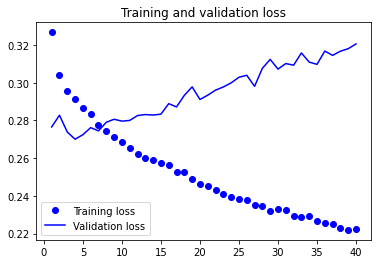

In [24]:
# 将上面的结果可视化
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()